# Acoustic propagation for a planar circular transducer (DPSM)

## Objectives

- Implement the 2D ultrasound propagation in an homogeneous medium according to the Distributed Point Source Method (DPSM) based on Yanagita et al. 2009.
- Evaluate the results of different point sources distributions and choose the one that gives the minimum error compared to the Rayleigh–Sommerfeld analitical solution for the 1D case.
- Study the convergence of the error increasing the number of point sources.
- Visualise the 2D acoustic field and, in presence of discretization artefacts, resolve them or find the proper spatial range for a reliable solution.
- Check the acoustic pressure distribution varying the distance from the transducer.

## Theory

The acoustic propagation for a planar transducer in a homogeneous medium is implemented using the Distributed Point Source Method (DPSM) as in Yanagita et all. 2009.

It comes from an approximation of the Rayleigh integral, with the hypothesis of continuous transducer surface velocity.

The planar tranducer is modeled with a set of point sources uniformly distributed in the transducer surface.
This is possible because, under certain conditions, the acoustic propagation from a point source has an analitical solution. The acoustic pressure generated by the planar transducer in an observation point is approximated to the sum of acoustic pressures generated by the point sources.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PySONIC.utils import logger, si_format, rmse
from PySONIC.neurons import getPointNeuron
from MorphoSONIC.sources import PlanarDiskTransducerSource
from MorphoSONIC.grids import grid_classes
from MorphoSONIC.models import SennFiber
from MorphoSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve

logger.setLevel(logging.INFO)

## Input parameters

In [3]:
# Transducer parameters
u_z = 1                          # transducer surface velocity (m/s)
c = 1490.0                       # medium speed of sound (m)
rho = 1e3                        # medium density (kg/m3)
r_tr = (2e-3) / 2                # transducer radius (m)
pos = (0, 0, 0)                  # transducer XYZ location (m)
freqs = [0.5e6, 1e6, 2e6, 5e6]   # US frequencies (Hz)
fref = freqs[0]                  # reference frequency

# Get list of distribution types
dists = list(grid_classes.keys())

# Conversion constants
M_TO_MM = 1e3
PA_TO_MPA = 1e-6

## Acoustic source: planar disk transducers

Let's define a set of planar disk transducers radiating at various frequencies.

In [4]:
psources = {
    Fdrive: PlanarDiskTransducerSource(
        pos, Fdrive, rho=rho, c=c, r=r_tr, u=u_z)
    for Fdrive in freqs
}

## Transducer surface discretization:  point source distributions

Let's test different way to model the circular transducer with point sources: 
- sunflower
- quadratic
- concentric circles (the one used in Yanagita 2009)

The key feature of all these distribution is the uniformity (needed for the DPS Method). 

At first, we plot the spatial distributions of the point sources. Then, we compare the DPSM resulting acoustic pressures with the analitical solution of the Rayleigh integral for the z-axis (the analitcal solution for the circular transducer is available only for the z axis, the one perpendicular to the transducer surface).

 04/04/2023 15:31:48: instantiating 682 sources with different methods...


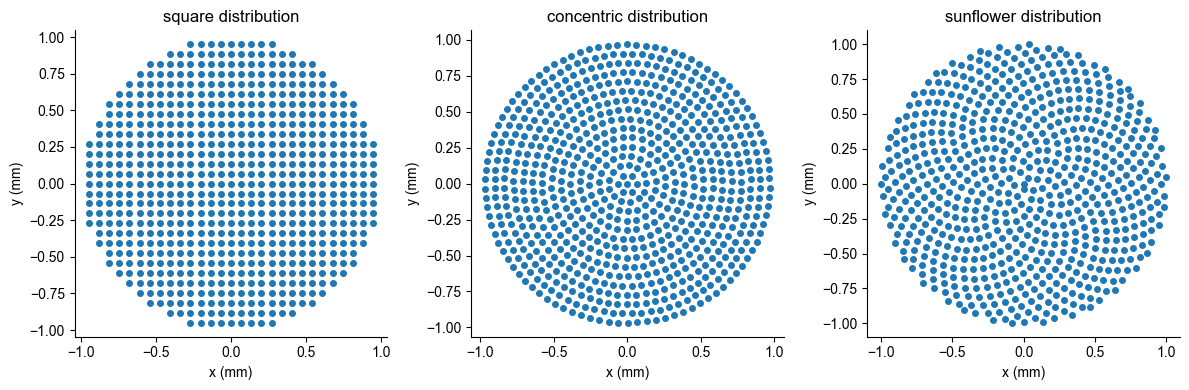

In [5]:
# Compute number of point sources
nsources = psources[fref].get_default_nsources()
logger.info(f'instantiating {nsources} sources with different methods...')
# Simulate and plot different point sources distributions 
fig, axes = plt.subplots(1, len(dists), figsize=(4 * len(dists), 4))
for ax, d in zip(axes, dists):
    sns.despine(ax=ax)
    x, y = psources[fref].getXYSources(m=nsources, d=d)
    ax.set_title(f'{d} distribution')
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.plot(x * M_TO_MM, y * M_TO_MM, 'o', markersize = 4)
fig.tight_layout()

## Pressure distribution along central propagation axis

Let's compare, for each carrier frequency, the pressure distribution along the central propagation axis computed with the DPSM method to that predicted with a reference analytical formula.

 04/04/2023 15:31:49: f = 0.50 MHz
 04/04/2023 15:31:49: computing amplitudes with square source distribution...
 04/04/2023 15:31:49: computing amplitudes with concentric source distribution...
 04/04/2023 15:31:49: computing amplitudes with sunflower source distribution...
 04/04/2023 15:31:49: f = 1.00 MHz
 04/04/2023 15:31:49: computing amplitudes with square source distribution...
 04/04/2023 15:31:49: computing amplitudes with concentric source distribution...
 04/04/2023 15:31:49: computing amplitudes with sunflower source distribution...
 04/04/2023 15:31:49: f = 2.00 MHz
 04/04/2023 15:31:49: computing amplitudes with square source distribution...
 04/04/2023 15:31:49: computing amplitudes with concentric source distribution...
 04/04/2023 15:31:49: computing amplitudes with sunflower source distribution...
 04/04/2023 15:31:49: f = 5.00 MHz
 04/04/2023 15:31:49: computing amplitudes with square source distribution...
 04/04/2023 15:31:49: computing amplitudes with concentric 

/Users/tlemaire/Documents/code/MorphoSONIC/MorphoSONIC/sources/acoustic.py:359: RuntimeWarning: divide by zero encountered in divide
  expmat = np.exp(j * self.kf * dmat) / dmat
/Users/tlemaire/Documents/code/MorphoSONIC/MorphoSONIC/sources/acoustic.py:359: RuntimeWarning: invalid value encountered in divide
  expmat = np.exp(j * self.kf * dmat) / dmat
/Users/tlemaire/Documents/code/MorphoSONIC/MorphoSONIC/sources/acoustic.py:363: RuntimeWarning: invalid value encountered in multiply
  return -j * self.rho * self.f * ds * self.u * expsum


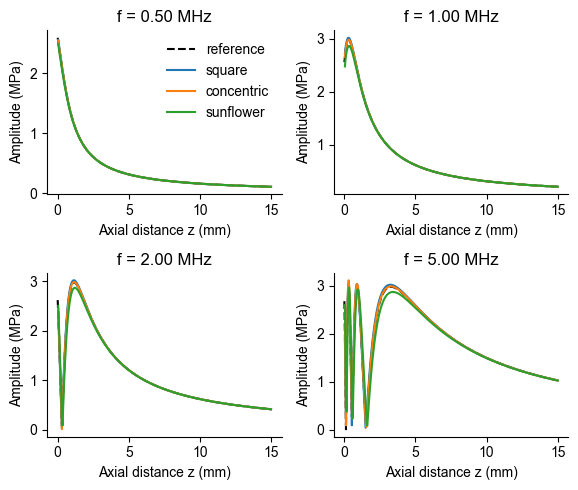

In [6]:
# Define axial evaluation vector
nperax = 401   # Number of samples in x, z
z = np.linspace(0, 15., nperax) / M_TO_MM  # m

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
sns.despine(fig=fig)
axes = axes.ravel()

# For each carrier frequency
for ax, (freq, psource) in zip(axes, psources.items()):
    s = f'f = {freq * 1e-6:.2f} MHz'
    logger.info(s)
    # Set axis
    ax.set_title(s)
    ax.set_xlabel('Axial distance z (mm)')
    ax.set_ylabel('Amplitude (MPa)')
    # Plot reference amplitudes along normal axis computed with analytical formula
    ax.plot(
        z * M_TO_MM, psource.normalAxisAmp(z) * PA_TO_MPA, 
        label='reference', linestyle='dashed', color='black')
    # For each point-source distribution type
    for d in dists:
        # Compute and plot amplitudes along normal axis
        logger.info(f'computing amplitudes with {d} source distribution...')
        amps = psource.DPSM_amps(0., 0., z, m=nsources, d=d)
        ax.plot(z * M_TO_MM, amps * PA_TO_MPA, label=d)

# Add legend on first axis, and reset layout
axes[0].legend(frameon=False)
fig.tight_layout()


From the figures above we can conclude that:
- At higher frequencies there are some near-field effects.


- The mismatches in the estimation of the acoustic pressure of the circular distributions is mostly in the field near the transducer (low z). 
    At high z the DPSM approximation converges in the analitical solution.


- The concentric distribution seems to be the best in all the z range for low frequencies, and for z > 2 mm for high frequency.

    The squared distribution seems to be the best for high frequency and low z ( z < 2 mm).

    The sunflower distribution seems to be the worst one in all the z range.


At very low z (about 100 nm) our model has a strange behaviour, and since we don't need the very near field, we can consider only the behaviour at z > 100 nm to evaluate the best point sources distribution to use. 
From the plots above we expect that the best distribution would be the concentric one.

### Comparison of different point sources distributions

Compare the resulting acoustic fields along the z direction (the only one for which we have an analitical solution) varying the number of point sources and the frequency of stimulation.
To do that we have to define a cost function: square root of the mean squared error.

 04/04/2023 15:31:49: computing RMSEs between DPSM predictions and analytical solution along central axis...


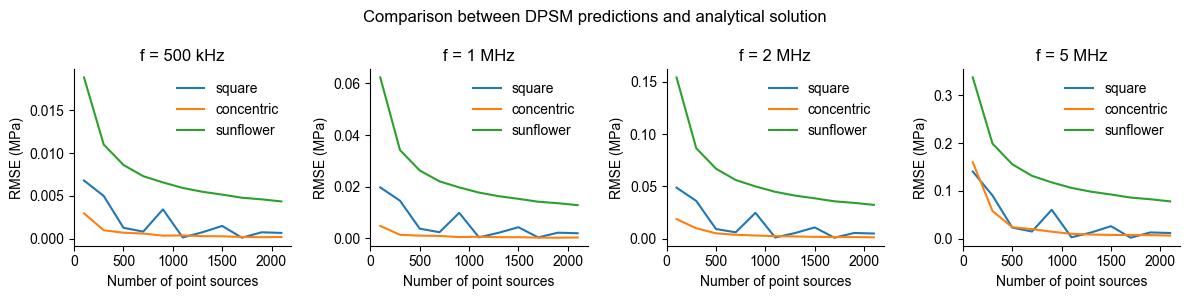

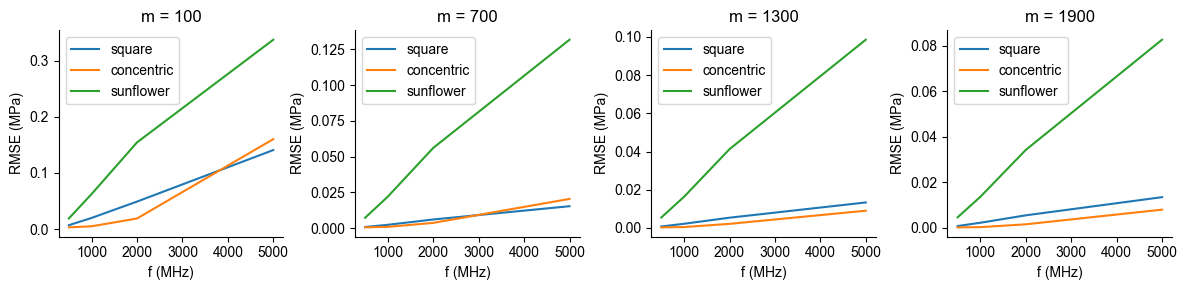

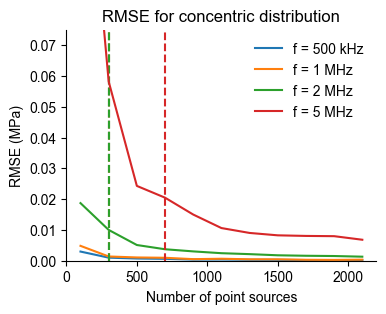

In [7]:
# Compute RMSEs for each frequency, number of sources, and distribution type
logger.info('computing RMSEs between DPSM predictions and analytical solution along central axis...')
nsources_sweep = np.linspace(100, 2100, 11).astype(int)
z_cut = z[3:]  # axial vector: discard most proximal locations
rmse_dict = {d: np.zeros((nsources_sweep.size, len(freqs))) for d in dists}
for j, freq in enumerate(freqs):
    refamps = psources[freq].normalAxisAmp(z_cut)
    for i, nsources in enumerate(nsources_sweep):
        for d in dists:
            amps = psources[freq].DPSM_amps(0., 0., z_cut, m=nsources, d=d)
            rmse_dict[d][i, j] = rmse(amps, refamps)

# Plot RMSE vs. number of sources for various carrier frequencies
fig, axes = plt.subplots(1, len(freqs), figsize=(len(freqs) * 3, 3))
fig.suptitle('Comparison between DPSM predictions and analytical solution')
sns.despine(fig=fig)
for idx_f, (ax, f) in enumerate(zip(axes, freqs)):
    ax.set_title(f'f = {si_format(f)}Hz') 
    for dtype, rmse_vec in rmse_dict.items():
        ax.plot(nsources_sweep, rmse_vec[:, idx_f] * PA_TO_MPA, label=dtype)
    ax.set_xlabel('Number of point sources')
    ax.set_ylabel('RMSE (MPa)')
    ax.legend(frameon=False)
fig.tight_layout()

# Plot RMSE vs. frequency for various number of sources
nsources_sparse = nsources_sweep[::3]
f = np.array(freqs) * 1e-3
fig, axes = plt.subplots(1, nsources_sparse.size, figsize=(3 * nsources_sparse.size, 3))
sns.despine(fig=fig)
for ax, nsources in zip(axes, nsources_sparse):
    ax.set_title(f'm = {nsources}')
    idx_nsources = np.where(nsources_sweep == nsources)[0][0]
    for dtype, rmse_vec in rmse_dict.items():
        ax.plot(f, rmse_vec[idx_nsources, :] * PA_TO_MPA, label=dtype)
    ax.set_xlabel('f (MHz)')
    ax.set_ylabel('RMSE (MPa)')
    ax.legend()
fig.tight_layout()

# Analyse the convergence of RMSE for concentric distribution at different frequencies
# To get a proper value of point sources needed
fig, ax = plt.subplots(figsize=(4, 3))
sns.despine(fig=fig)
ax.set_title('RMSE for concentric distribution')
ax.set_xlabel('Number of point sources')
ax.set_ylabel('RMSE (MPa)')
# For each carrier frequency
for idx_f, f in enumerate(freqs):
    # Extract and plot RMSE vs. number of sources
    rmse_vec = rmse_dict['concentric'][:, idx_f]
    ax.plot(nsources_sweep, rmse_vec * PA_TO_MPA, label=f'f = {si_format(f)}Hz', c=f'C{idx_f}')
    # Extract and mark number of sources at which RMSE converges
    iconv = np.where(np.abs(np.diff(rmse_vec)) < 1e4)[0][0] + 1
    nsources_conv = nsources_sweep[iconv]
    ax.axvline(x=nsources_conv, ls='--', c=f'C{idx_f}')
ax.set_ylim(0,.075)
ax.legend(frameon=False)

From the figures above we can conclude that: 
- Increasing the frequency increase also the error. 


- The best point sources distribution is the concentric one, given the lower error and the smoothness of the curve. This is in accordance with the visual observations we made before. 

    The squared distribution has good performance too and the same convergence value, but it is more discountinuous.

    The sunflower distribution has the worst performance for each frequency and each number of point sources, and show an higher convergence value comparing to the other two distributions. This may be due to the non-uniformity that we see in the centre of the spatial distribution and this hypothesis agrees with the observation that the mismatch with the analitical solution is higher for low z values. 


- Considering the concentric distribution, the number of point sources at which we reach the convergence depends on the frequency. To decide the number of point sources to be used we need a trade off between the error and the computational complexity of the model. So we highligth the elbow points (increasing from these points will give a low improvement): for 500 kHz and 1 MHz is around 300, for 2 MHz 700, for 5 MHz 1100. We can use the maximum one (1100) to be sure to obtain a good approximation at each frequency. 

    To generalize the result and to use it for transducer of every shape and dimension, we can use the equivalent density: 217 point sources / $mm^2$. It garantees an RMSE below 20 kPa for a maximum frequency of 5 MHz. From now on we are going to use this density to model US transducers.

## 2D acoustic field

### Naive approach

Let's compute the 2D acoustic pressure distribution generated by the transducer:

 04/04/2023 15:31:52: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:31:52: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:31:59: Batch completed in 0:00:07.22 s
 04/04/2023 15:31:59: max amplitude: Pmax = 3 MPa
 04/04/2023 15:31:59: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:32:00: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:07: Batch completed in 0:00:07.50 s
 04/04/2023 15:32:07: max amplitude: Pmax = 3 MPa
 04/04/2023 15:32:07: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:32:07: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:15: Batch completed in 0:00:07.24 s
 04/04/2023 15:32:15: max amplitude: Pmax = 3 MPa
 04/04/2023 15:32:15: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:32:15: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:22: Batch completed in 0:00:07.04 s
 04/04/2023 15:32:22: max amplitude: Pmax = 3 MPa


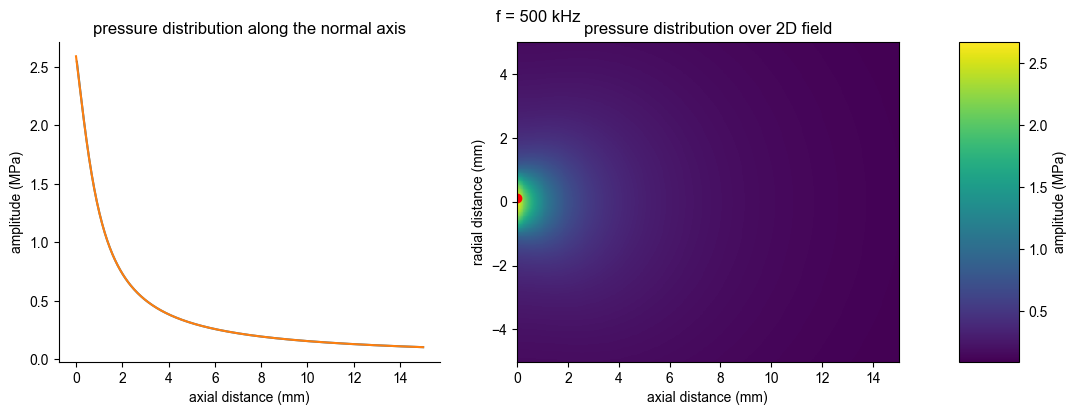

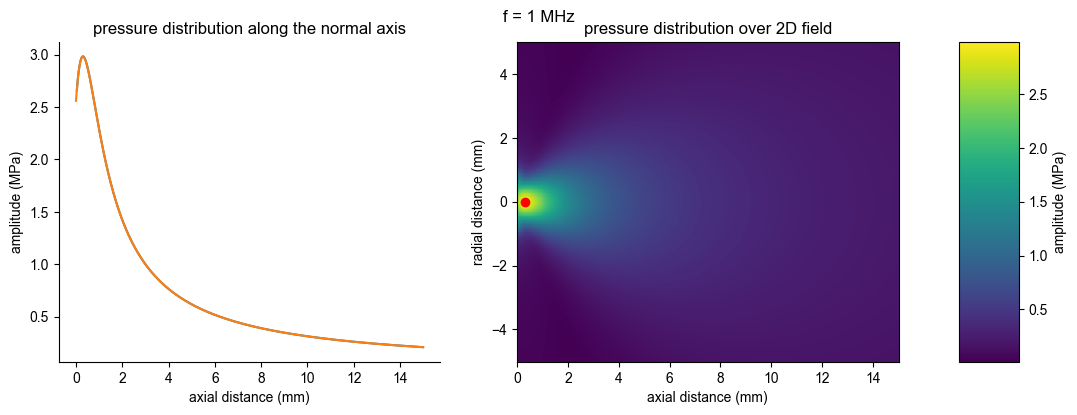

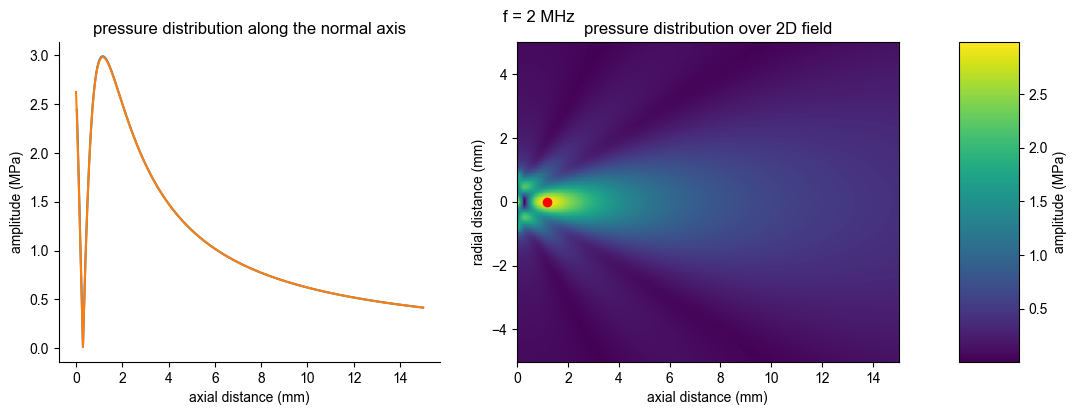

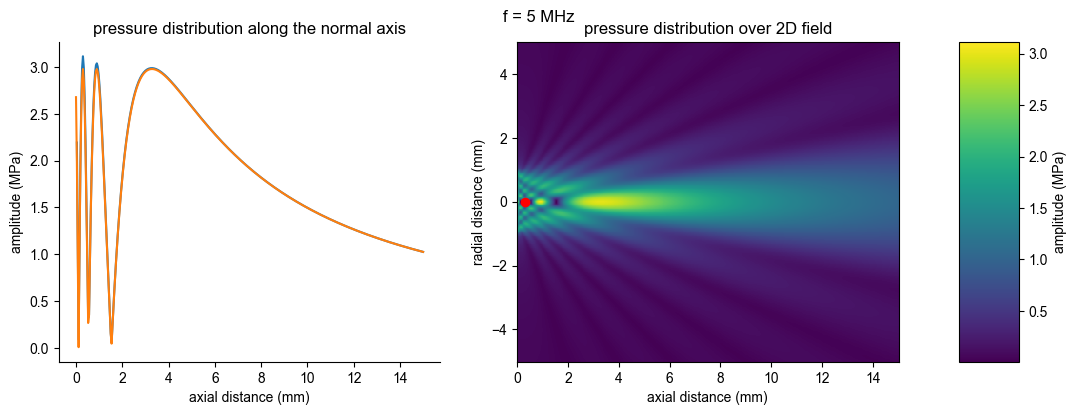

In [8]:
def plotAmpDist(x, z, amps, refamps):
    ''' Plot amplitude distribution along normal axis and over 2D field '''
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)

    # Plot pressure distribution along normal axis
    ax = axes[0]
    sns.despine(ax=ax)
    ax.set_title('pressure distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('amplitude (MPa)')
    ax.plot(z * M_TO_MM, amps[int(x.size / 2), :] * PA_TO_MPA)
    ax.plot(z * M_TO_MM, refamps * PA_TO_MPA)

    # Plot 2D pressure field
    ax = axes[1]
    ax.set_title('pressure distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * M_TO_MM, x * M_TO_MM, amps * PA_TO_MPA, cmap='viridis')
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('amplitude (MPa)')
    
    # Identify and mark XZ point of max pressure
    imax = np.unravel_index(np.nanargmax(amps, axis=None), amps.shape)
    xmax, zmax = x[imax[0]], z[imax[1]]
    assert np.nanmax(amps) == amps[imax[0], imax[1]]
    ax.scatter(zmax * M_TO_MM, xmax * M_TO_MM, c='r')
    logger.info(f'max amplitude: Pmax = {si_format(np.nanmax(amps))}Pa')
    
    # Return figure
    return fig

# Generate transverse evaluation vector
x = np.linspace(-5, 5, nperax) / M_TO_MM  # m

# Plot acoustic amplitudes over 2D grid for each frequency
for Fdrive in freqs:
    logger.info(f'computing XZ pressure field for f = {f * 1e-6:.2f} MHz')
    amps = psources[Fdrive].DPSM_amps(x, 0., z)  # Pa
    refamps = psources[Fdrive].normalAxisAmp(z)
    fig = plotAmpDist(x, z, amps, refamps)
    fig.suptitle(f'f = {si_format(Fdrive)}Hz', fontsize=12)

The color plots of the 2D acoustic pressure at high frequencies (2 MHz, 5 MHz) suggest some very high values of pressure (around 8 MPa, see printed values) at very low z.

It can be a discretization artefact at very low z (comparable to the distance between point sources), and we could expect it.

### Visualisation of discretization artefacts in the near-field

We want to visualise this discretization error. To do that we plot the pressure for the xy slices at low z to access the location of these maxima and the depth at which these high values disappear.

 04/04/2023 15:32:23: computing pressure fields over 200-by-200 XY grid for z = 0 m
 04/04/2023 15:32:23: Starting 2-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:24: Batch completed in 0:00:00.84 s
 04/04/2023 15:32:24: Starting 2-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:25: Batch completed in 0:00:00.88 s
 04/04/2023 15:32:25: Starting 2-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:26: Batch completed in 0:00:00.90 s
 04/04/2023 15:32:26: Starting 2-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:27: Batch completed in 0:00:00.97 s
 04/04/2023 15:32:27: computing pressure fields over 200-by-200 XY grid for z = 38 um
 04/04/2023 15:32:27: Starting 2-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:28: Batch completed in 0:00:01.02 s
 04/04/2023 15:32:28: Starting 2-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:29: Batch completed in 0:00:01.05 s
 04/04/2023 15:32:29: Starting 2-job(s) batch (multiprocessing enabled)
 0

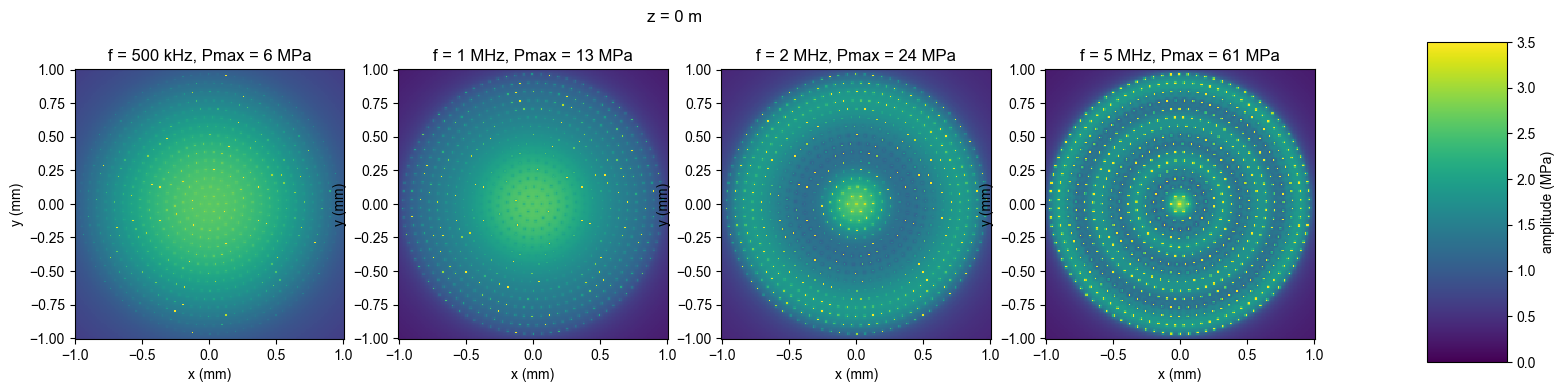

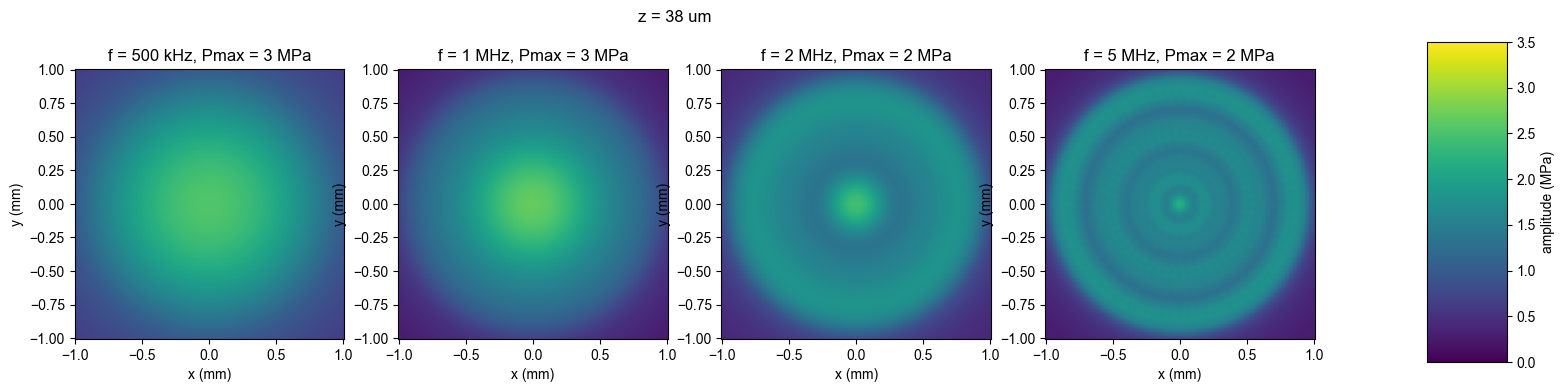

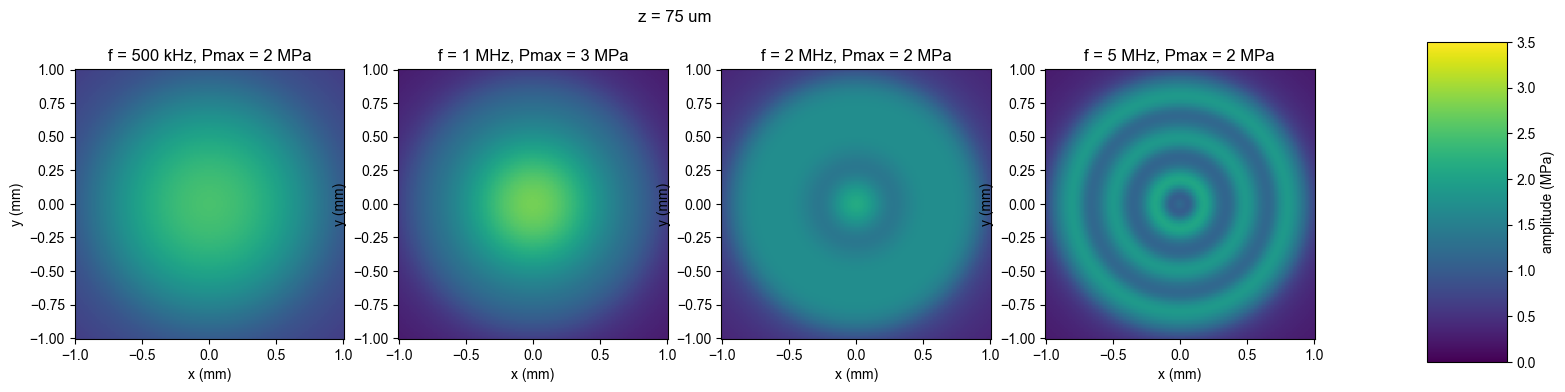

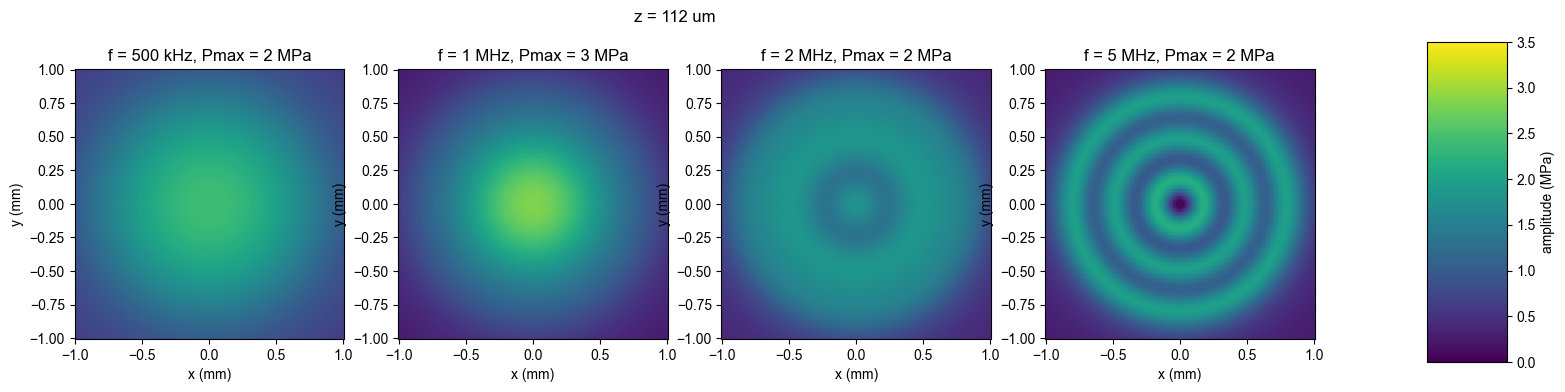

In [9]:
def plotXYslice(psources, xy, z, **kwargs):
    logger.info(f'computing pressure fields over {xy.size}-by-{xy.size} XY grid for z = {si_format(z)}m')
    # Create figure
    fig, axes = plt.subplots(1, len(psources), figsize=(4 * len(psources), 4))
    # For each carrier frequency
    for ax, (Fdrive, psource) in zip(axes, psources.items()):
        # Compute and plot 2D pressure field
        amps = psource.DPSM_amps(xy, xy, z, **kwargs)  # Pa
        sm = ax.pcolormesh(
            xy * M_TO_MM, xy * M_TO_MM, amps * PA_TO_MPA,
            cmap='viridis', vmin=0, vmax=3.5)
        # Post-process axis
        ax.set_title(f'f = {si_format(Fdrive)}Hz, Pmax = {si_format(np.nanmax(amps))}Pa')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        ax.set_aspect(1.)
    # Add colorbar
    cbarax = fig.add_axes([0.97, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('amplitude (MPa)')
    fig.suptitle(f'z = {si_format(z)}m')

# For the first 4 z-slices over dense XY grid
xydense = np.linspace(-r_tr, r_tr, 200)  # m
for zz in z[:4]:
    plotXYslice(psources, xydense, zz)

- The maxima are located on the point sources, it confirms that this is a discretization artefact.


- The max initial values of pressure seems to depend on frequency: higher the frequency higher the initial value.


- The ultrasound field seems ok from the second slice. 

Studying the dependencies of the max initial values is difficult because they are very local and decrease fastly, so the max value we achieve highly depends on the grid xy on which we are computing the ultrasound field. Moreover, we don't really need to estimate this max value: what we really need for our model is the depth required to get the right range of pressures.

We want to verify if the depth depend also on the number of point sources, density of point sources or dimension of the transducer surface. So in the next tests we are going to separate these variables to identify the real dependencies.

 04/04/2023 15:32:41: computing pressure fields over 200-by-200 XY grid for z = 0 m
 04/04/2023 15:32:42: computing pressure fields over 200-by-200 XY grid for z = 38 um
 04/04/2023 15:32:43: computing pressure fields over 200-by-200 XY grid for z = 75 um
 04/04/2023 15:32:43: computing pressure fields over 200-by-200 XY grid for z = 112 um


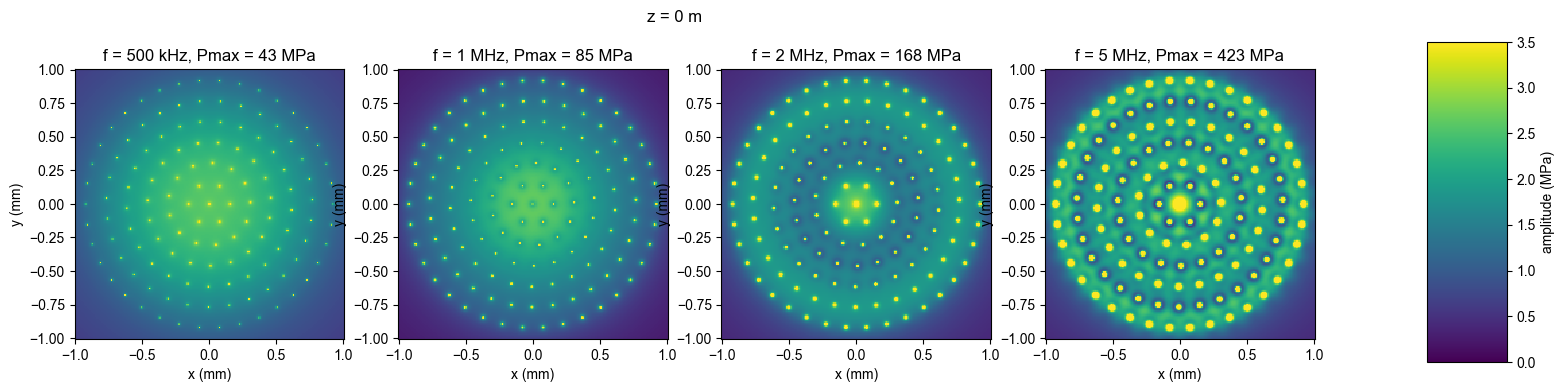

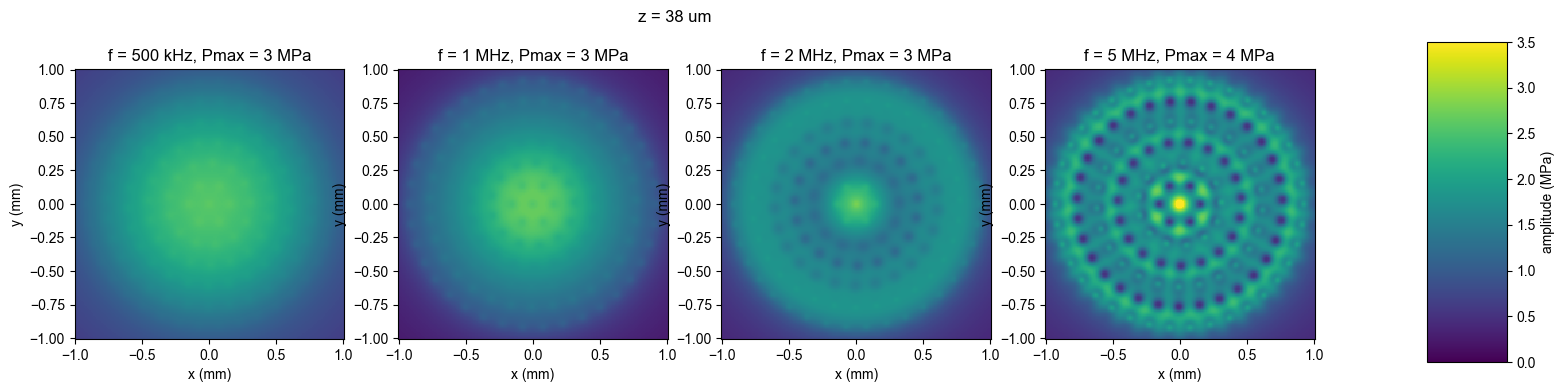

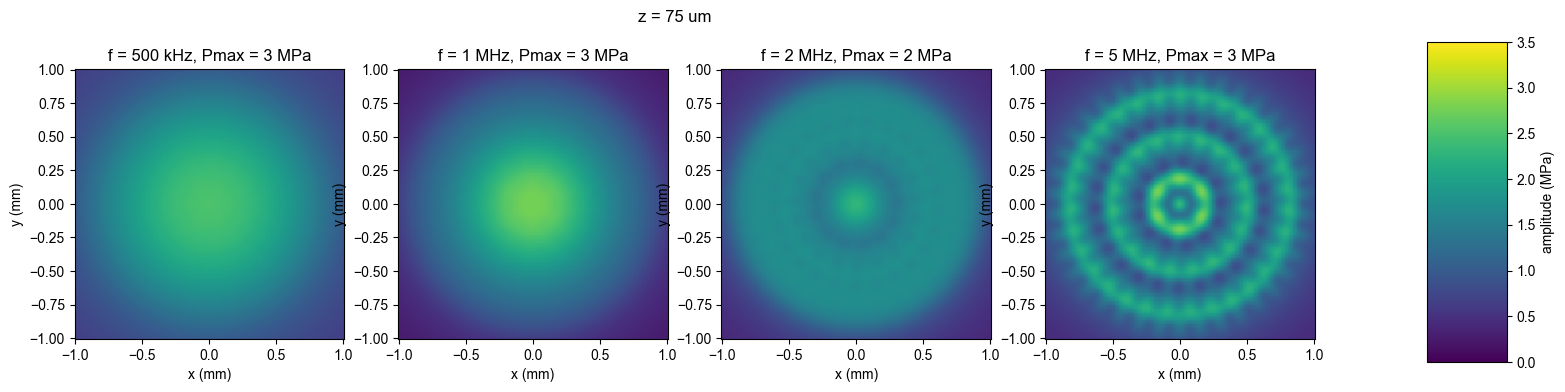

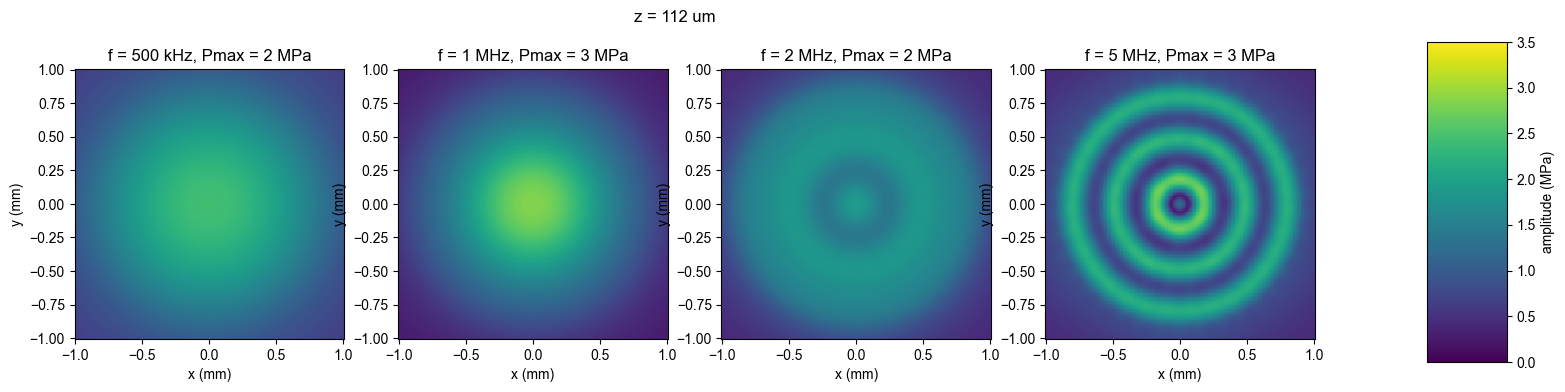

In [10]:
# Same transducer surface, lower number of point sources
# Lower density of point sources
for zz in z[:4]:
    plotXYslice(psources, xydense, zz, m=100)

 04/04/2023 15:32:46: computing pressure fields over 200-by-200 XY grid for z = 0 m
 04/04/2023 15:32:47: computing pressure fields over 200-by-200 XY grid for z = 38 um
 04/04/2023 15:32:47: computing pressure fields over 200-by-200 XY grid for z = 75 um
 04/04/2023 15:32:48: computing pressure fields over 200-by-200 XY grid for z = 112 um


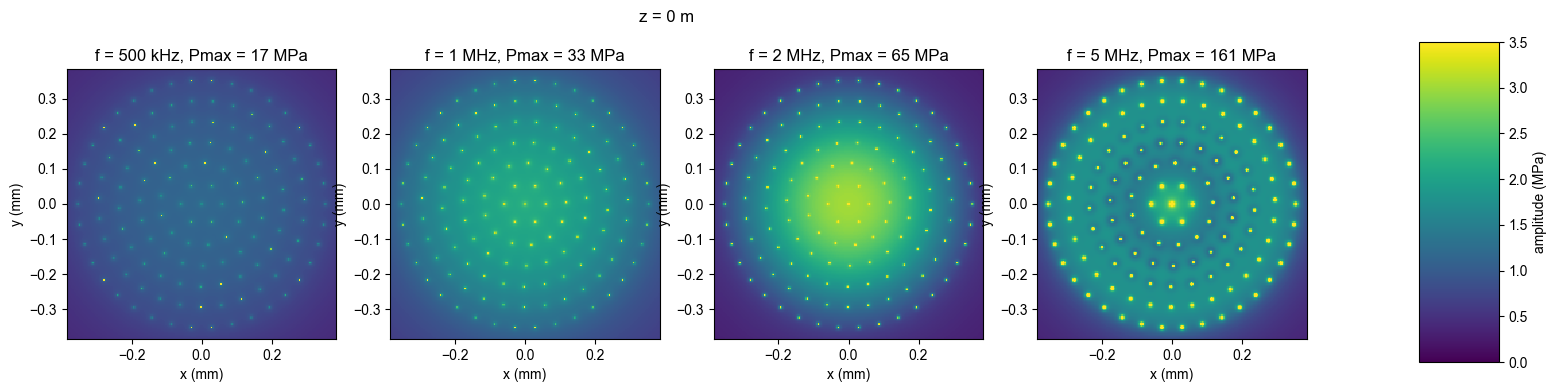

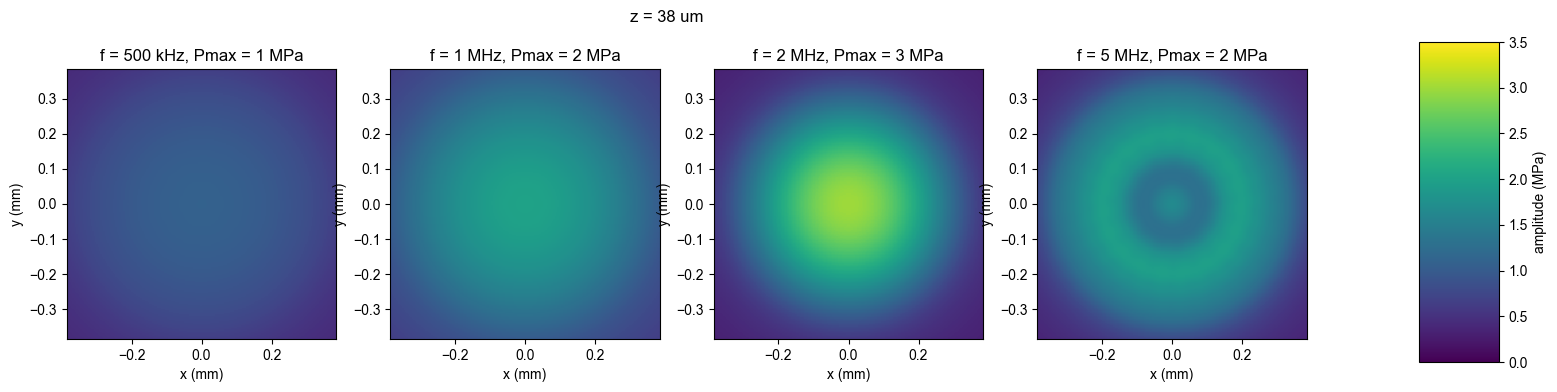

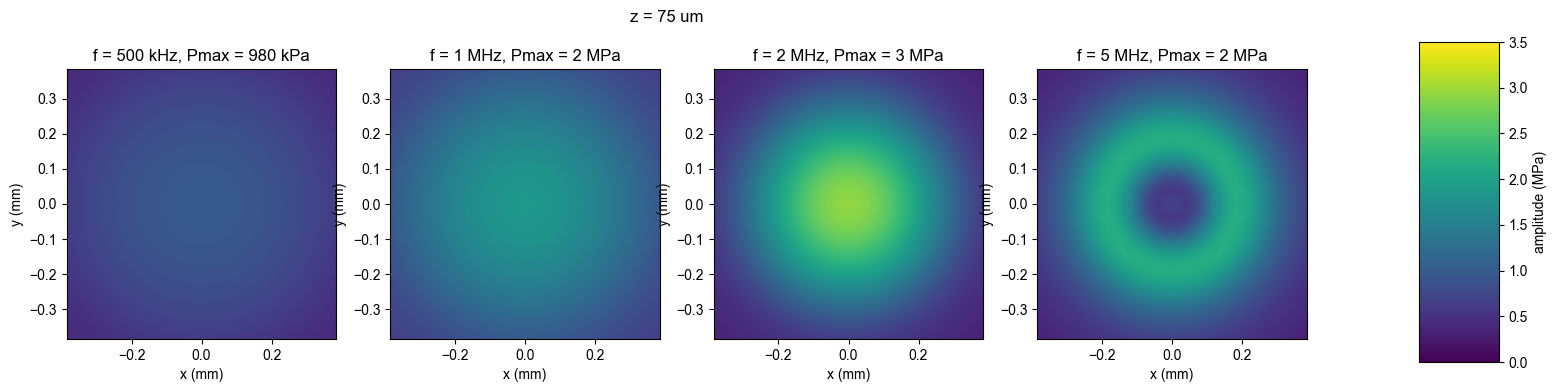

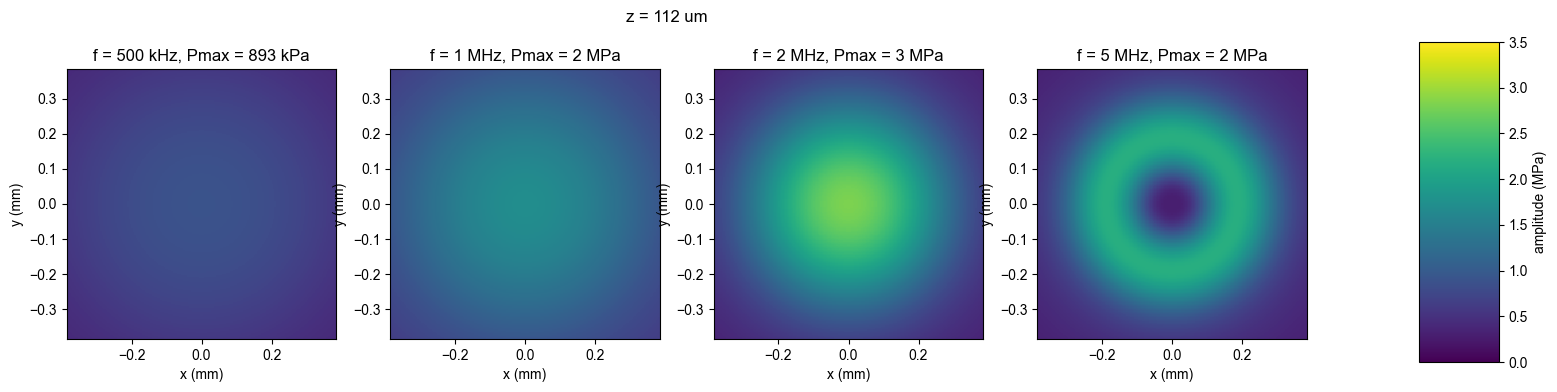

In [11]:
# Lower transducer surface, lower number of point sources
# Same density of point sources (comparing to the first trial)

density = 217e6  # point sources / m^2
m = 100
radius = np.sqrt (m / (density * np.pi))  # m
psources_small = {
    Fdrive: PlanarDiskTransducerSource(pos, Fdrive, rho=rho, c=c, u=u_z, r=radius)
    for Fdrive in freqs
}
xydense = np.linspace(-radius, radius, 200)  # m
for zz in z[:4]:
    plotXYslice(psources_small, xydense, zz, m=m)

The US field at very low z is highly dependent on the specific point source distribution chosen, so it is not reliable and useful for any application.

From the results above, we can assert that the depth required to get the right range of pressures depends on the frequency and the density of point sources:
- Higher is the frequency, thicker is the layer to be removed
- Higher is the density of point sources, thinner is the layer to be removed


Considering the density of point sources fixed at 217 point sources / $mm^2$, the results are reliable up to 5 MHz removing the very first layer of about 100 um (3 samples for our z-axis resolution).

### Refined visualisation (discretization artefacts removed)

 04/04/2023 15:32:51: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:32:51: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:32:59: Batch completed in 0:00:08.21 s
 04/04/2023 15:32:59: max amplitude: Pmax = 3 MPa
 04/04/2023 15:32:59: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:32:59: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:06: Batch completed in 0:00:06.79 s
 04/04/2023 15:33:06: max amplitude: Pmax = 3 MPa
 04/04/2023 15:33:06: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:33:06: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:13: Batch completed in 0:00:07.03 s
 04/04/2023 15:33:13: max amplitude: Pmax = 3 MPa
 04/04/2023 15:33:13: computing XZ pressure field for f = 5.00 MHz
 04/04/2023 15:33:13: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:21: Batch completed in 0:00:07.89 s
 04/04/2023 15:33:22: max amplitude: Pmax = 3 MPa


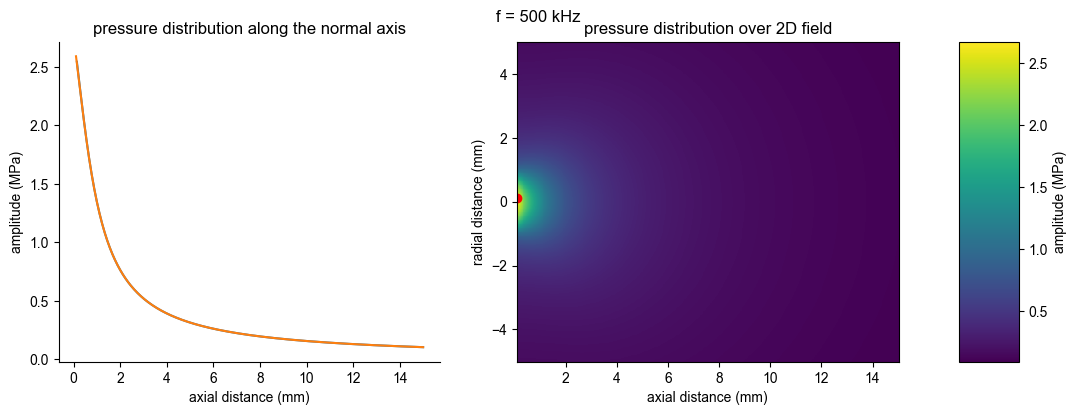

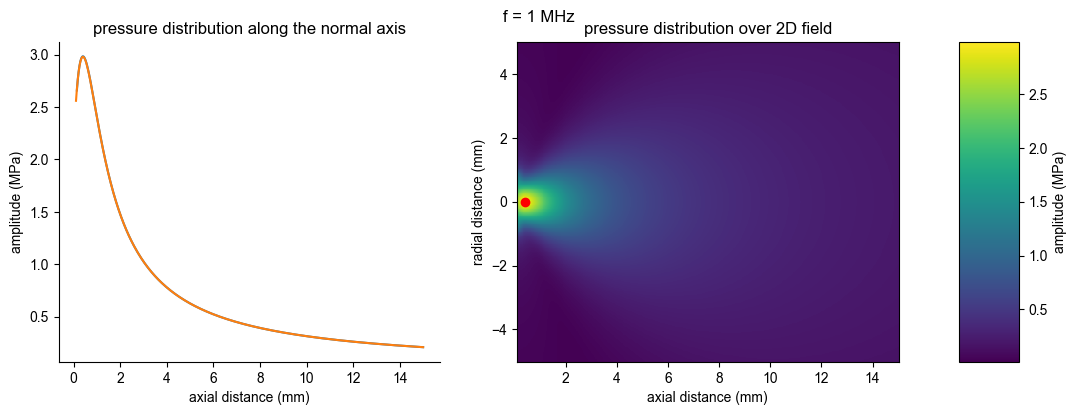

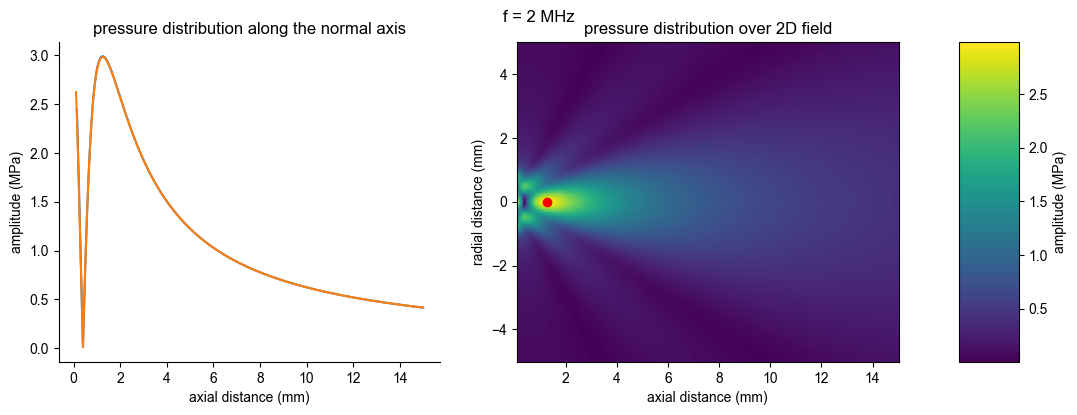

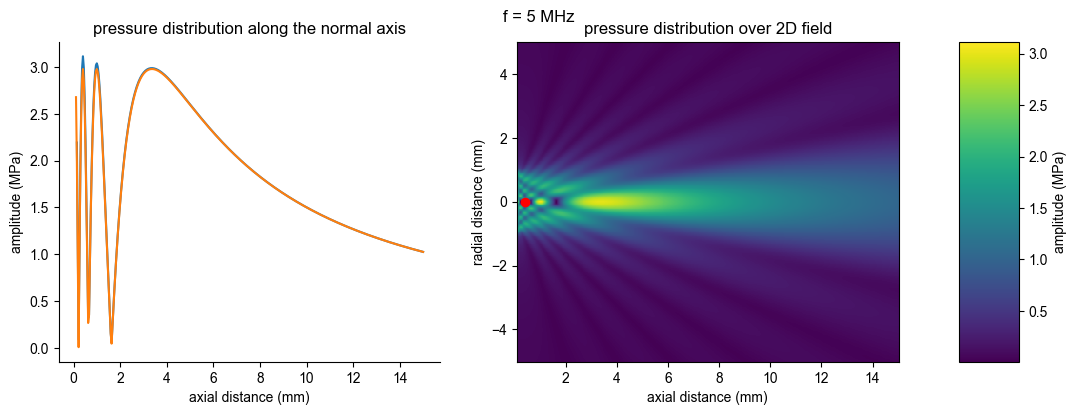

In [12]:
# Generate 2D square grid
z_fixed = np.linspace(0.1, 15, nperax) / M_TO_MM  # m (without the first 100 um)

# Plot acoustic amplitudes over 2D grid for each frequency
for Fdrive in freqs:
    logger.info(f'computing XZ pressure field for f = {f * 1e-6:.2f} MHz')
    amps = psources[Fdrive].DPSM_amps(x, 0., z)  # Pa
    refamps = psources[Fdrive].normalAxisAmp(z)
    fig = plotAmpDist(x, z_fixed, amps, refamps)
    fig.suptitle(f'f = {si_format(Fdrive)}Hz', fontsize=12)

# # Plot acoustic amplitudes over 2D grid for each frequency
# for Fdrive in freqs:
#     source = PlanarDiskTransducerSource(pos, Fdrive, u=1, r=r_tr)
#     amps = source.DPSM2d (x, z)  # Pa
#     refamps = source.normalAxisAmp (z)
#     fig = plotAmpDist(x, z, amps, refamps)
#     fig.suptitle(f'Fdrive = {si_format(Fdrive)}Hz', fontsize=12)

Now the ultrasound fields are in the correct range of values amd the maximum for all the frequencies is on the z axis: we have correctly removed the artifacts.


As we can see, for higher frequencies we have:
- Higher directionality 


- Higher near-field effect

### Acoustic distribution along fiber

Let's check the resulting acoustic pressure distribution at different distances from the transducer. 

This can be useful to visualise the pressure that would affect a fiber placed orthogonally to the acoustic propagation axis.

 04/04/2023 15:33:23: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:30: Batch completed in 0:00:07.18 s
 04/04/2023 15:33:31: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:38: Batch completed in 0:00:07.25 s
 04/04/2023 15:33:38: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:46: Batch completed in 0:00:07.76 s
 04/04/2023 15:33:46: Starting 8-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:53: Batch completed in 0:00:07.30 s


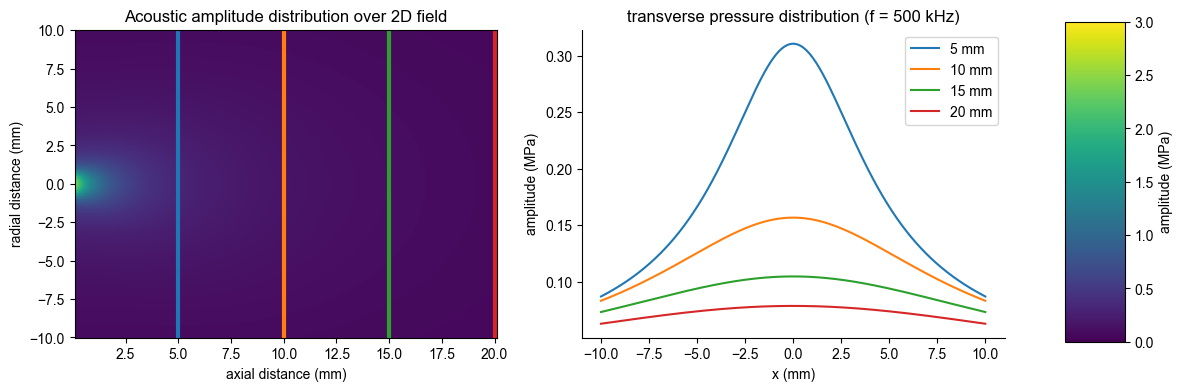

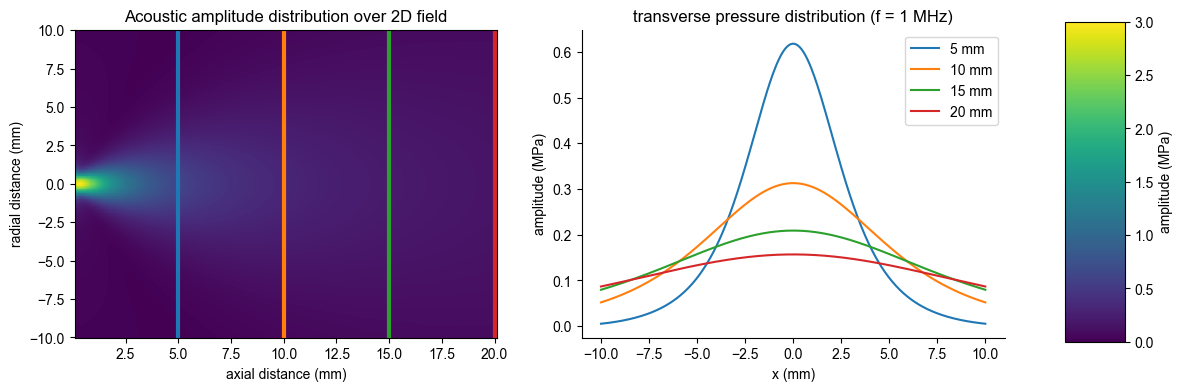

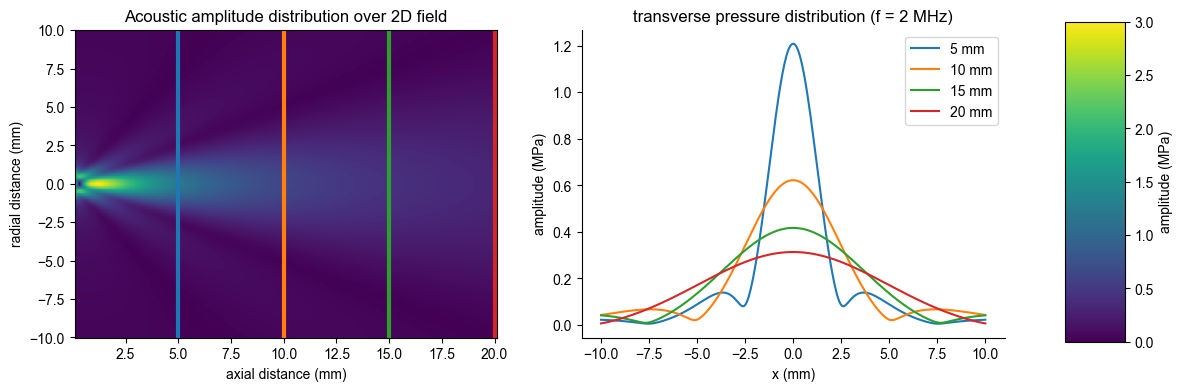

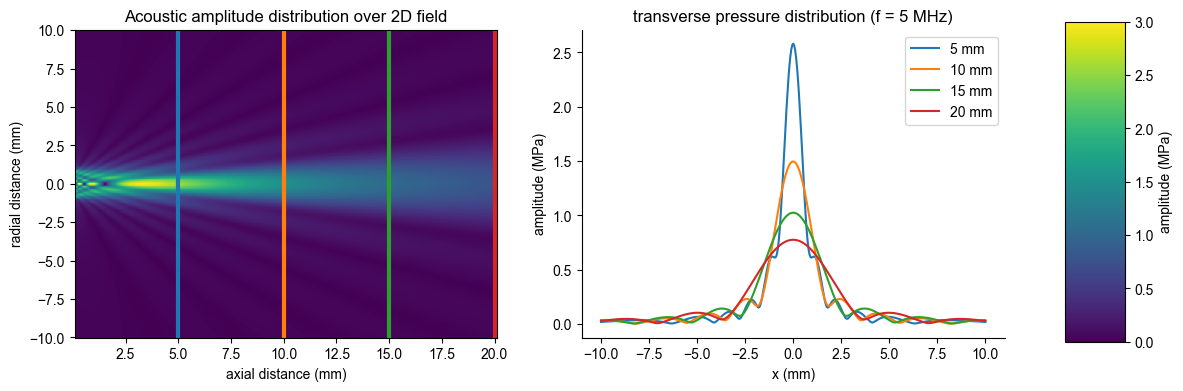

In [13]:
def plotTransverseAmpDist(Fdrive, x, z, amps, zcurves):
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 2D pressure field
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * M_TO_MM, x * M_TO_MM, amps * PA_TO_MPA,
                       cmap='viridis', vmin=0, vmax=3)
    cbarax = fig.add_axes([0.95, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('amplitude (MPa)')

    # Add lines for characteristic distances
    for i, zc in enumerate(zcurves):
        ax.axvline(x=zc * M_TO_MM, color=f'C{i}', linewidth=3)
    
    # Plot transverse pressure profiles for characteristic distances
    ax = axes[1]
    sns.despine(ax=ax)
    ax.set_title(f'transverse pressure distribution (f = {si_format(Fdrive)}Hz)')
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('amplitude (MPa)')
    for i, zc in enumerate(zcurves):
        ax.plot(
            x * M_TO_MM, amps[:, np.argmin(np.abs(z - zc))] * PA_TO_MPA,
            color=f'C{i}', label=f'{si_format(zc)}m')
    ax.legend()

    return fig


x = np.linspace(-10, 10, nperax) / M_TO_MM  # m
z = np.linspace(0.1, 20.1, nperax) / M_TO_MM  # m
zcurves = np.array([5, 10, 15, 20]) / M_TO_MM  # m
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM_amps(x, 0., z)  # Pa
    plotTransverseAmpDist(Fdrive, x, z, amps, zcurves)

Higher frequency means higher peak pressure amplitude and more selective field. 

### Acoustic field varying the transducer dimension

 04/04/2023 15:33:55: Starting 6-job(s) batch (multiprocessing enabled)
 04/04/2023 15:33:59: Batch completed in 0:00:04.57 s
 04/04/2023 15:34:00: max amplitude: Pmax = 2 MPa
 04/04/2023 15:34:00: Starting 6-job(s) batch (multiprocessing enabled)
 04/04/2023 15:34:04: Batch completed in 0:00:04.36 s
 04/04/2023 15:34:04: max amplitude: Pmax = 3 MPa
 04/04/2023 15:34:04: Starting 6-job(s) batch (multiprocessing enabled)
 04/04/2023 15:34:09: Batch completed in 0:00:04.51 s
 04/04/2023 15:34:09: max amplitude: Pmax = 3 MPa
 04/04/2023 15:34:09: Starting 6-job(s) batch (multiprocessing enabled)
 04/04/2023 15:34:14: Batch completed in 0:00:04.51 s
 04/04/2023 15:34:14: max amplitude: Pmax = 3 MPa


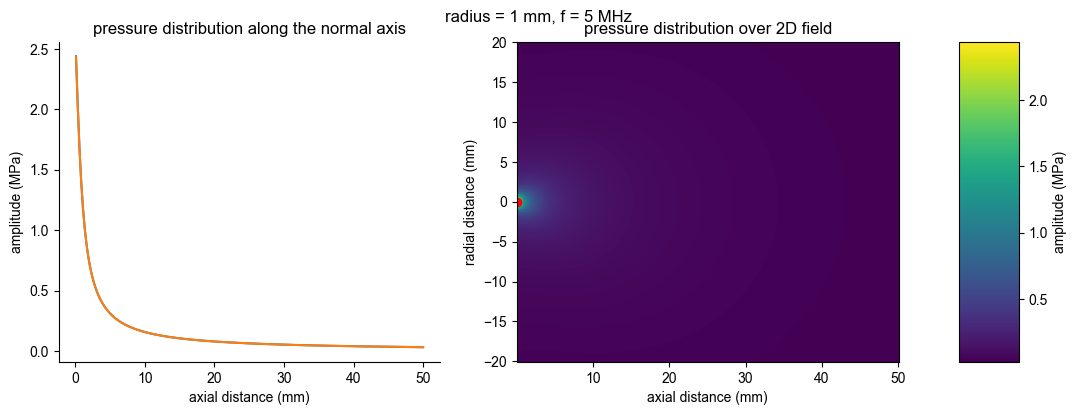

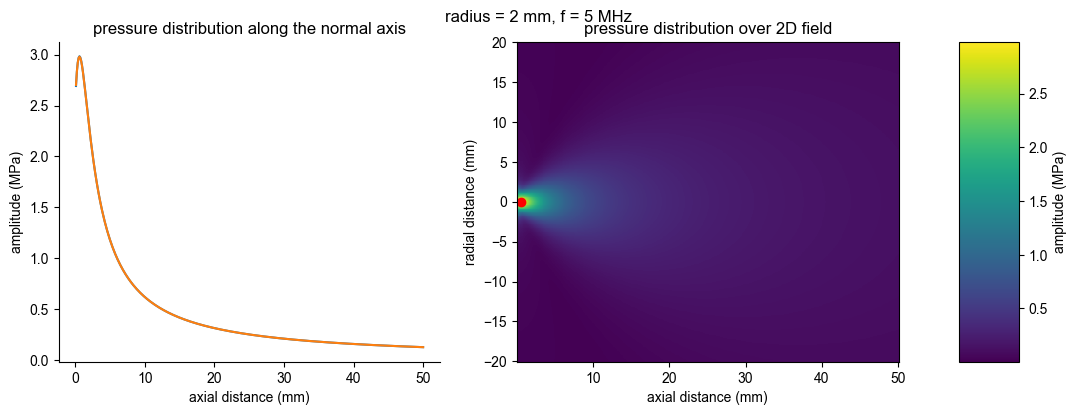

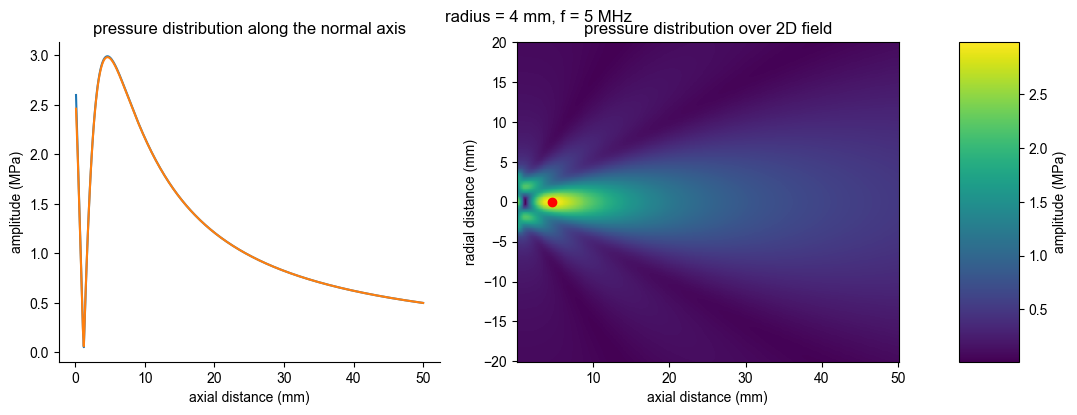

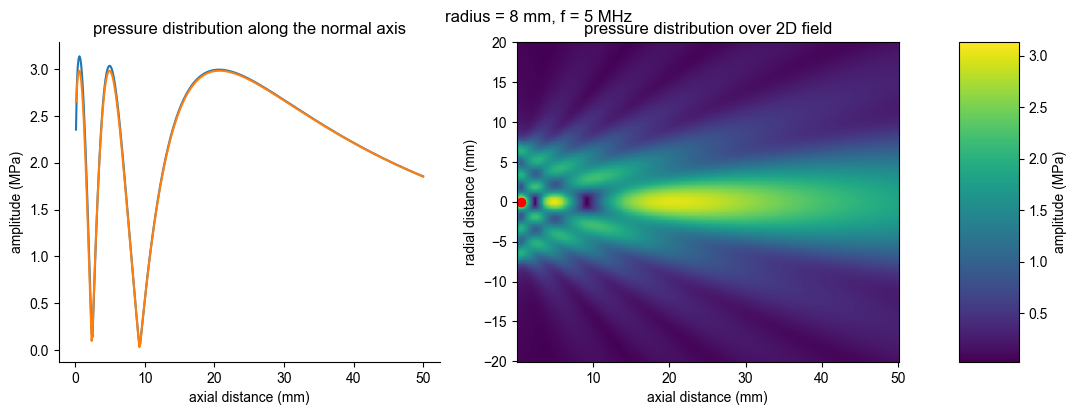

In [14]:
# Generate 2D square grid
x = np.linspace(-20, 20, nperax) / M_TO_MM  # m
z = np.linspace(0.1, 50, nperax) / M_TO_MM # m (without the first 100 um)

# Transducer radii
r_transducer_range = [1e-3, 2e-3, 4e-3, 8e-3]

# Plot acoustic amplitudes over 2D grid for each frequency
for r_tr in r_transducer_range:
    psource = PlanarDiskTransducerSource(pos, fref, rho=rho, c=c, r=r_tr, u=u_z)
    amps = psource.DPSM_amps(x, 0., z, m=500)  # Pa
    refamps = psource.normalAxisAmp(z)
    fig = plotAmpDist(x, z, amps, refamps)
    fig.suptitle(f'radius = {si_format(r_tr)}m, f = {si_format(Fdrive)}Hz')

### US field generated by a big transducer (diameter 19 mm)

 04/04/2023 15:36:41: Starting 6-job(s) batch (multiprocessing enabled)
 04/04/2023 15:36:46: Batch completed in 0:00:05.54 s
 04/04/2023 15:36:46: max amplitude: Pmax = 3 MPa


Text(0.5, 0.98, 'd = 19 mm, f = 500 kHz')

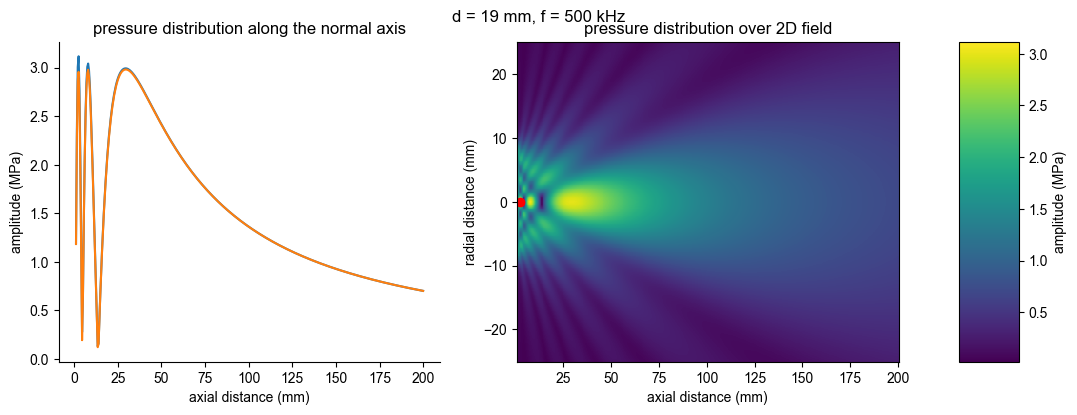

In [20]:
# Generate 2D square grid
x = np.linspace(-25, 25, nperax) / M_TO_MM  # m
z = np.linspace(1, 200, nperax) / M_TO_MM  # m (without the first mm)
r_tr = 19e-3 / 2

psource = PlanarDiskTransducerSource(pos, fref, rho=rho, c=c, u=u_z, r=r_tr)
amps = psource.DPSM_amps(x, 0., z, m=500)  # Pa
refamps = psource.normalAxisAmp(z)
fig = plotAmpDist(x, z, amps, refamps)
fig.suptitle(f'd = {si_format(r_tr * 2)}m, f = {si_format(fref)}Hz')

## Conclusions
We obtain the 2D ultrasound propagation for a planar circular transducer in a homogeneous medium validated on the Yanagita et al. 2009 paper results.

Features of the DPSM tranducer model: 
- Type of point sources distribution: concentric 
- Point source density ( RMSE < 20 kPa under 5 MHz ) : around 217 point sources / $mm^2$
- Depth of the initial layer removed: 100 um

## References
- Yanagita T., Kundu T., Placko D., "Ultrasonic field modeling by distributed point source method for different transducer boundary conditions.", J. Acoust. Soc. Am. 2009 Nov; 126(5):2331-9. doi: 10.1121/1.3203307. https://bit.ly/2kiNwaS


- Cheng J., Lin W., Qin Y., " Extension of the distributed point source method for ultrasonic field modeling", Ultrasonics 2010.

